# #11 Mean-Variance Portfolio


[ref](https://mkjjo.github.io/finance/2019/01/27/mean-variance-portfolio.html)<br>
[ref 2](https://github.com/vsmolyakov/fin/blob/master/portfolio_opt.py):

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

from pandas.plotting import scatter_matrix
from scipy.spatial import ConvexHull
from sklearn.neighbors import KDTree

from datetime import datetime

np.random.seed(0)

In [2]:
tickers = ['MSFT', 'TLT', 'SPY', 'VTIP', 'VCLT', 'IAU', 'BCI']
df = yf.download(tickers, start='2017-06-01', end='2023-04-01')['Adj Close']
df.head()

[*********************100%***********************]  7 of 7 completed


,BCI,IAU,MSFT,SPY,TLT,VCLT,VTIP
Date,,,,,,,
2017-06-01,15.392171,24.420000,65.030838,218.480804,108.937920,73.038734,41.170410
2017-06-02,15.392171,24.580000,66.570793,219.208008,110.227814,73.720497,41.187057
2017-06-05,15.290108,24.620001,67.053177,219.046448,109.543358,73.363724,41.153763
2017-06-06,15.290108,24.900000,67.275833,218.346161,110.140045,73.736359,41.220329
2017-06-07,15.290108,24.780001,67.155258,218.750153,109.613564,73.585732,41.137119


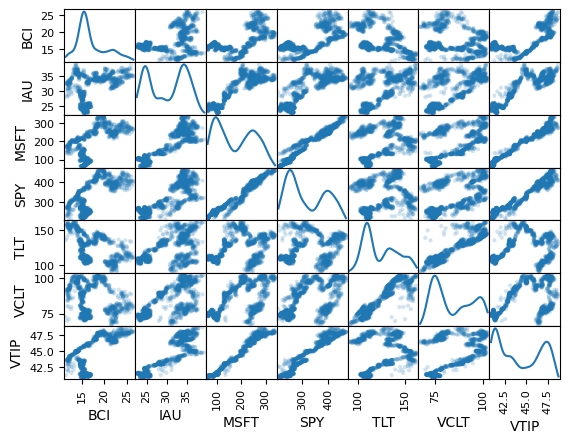

In [3]:
# correlations between (the price of) assets
scatter_matrix(df, alpha=0.2, diagonal='kde')
plt.show()

In [4]:
ret = df.pct_change().dropna() * 100
ret.head()

,BCI,IAU,MSFT,SPY,TLT,VCLT,VTIP
Date,,,,,,,
2017-06-02,0.000000,0.655200,2.368038,0.332845,1.184063,0.933426,0.040435
2017-06-05,-0.663085,0.162738,0.724618,-0.073702,-0.620947,-0.483954,-0.080838
2017-06-06,0.000000,1.137282,0.332059,-0.319698,0.544704,0.507928,0.161751
2017-06-07,0.000000,-0.481923,-0.179225,0.185023,-0.478011,-0.204278,-0.201866
2017-06-08,0.041733,-0.726393,-0.607850,0.049254,-0.264142,-0.172369,-0.060711


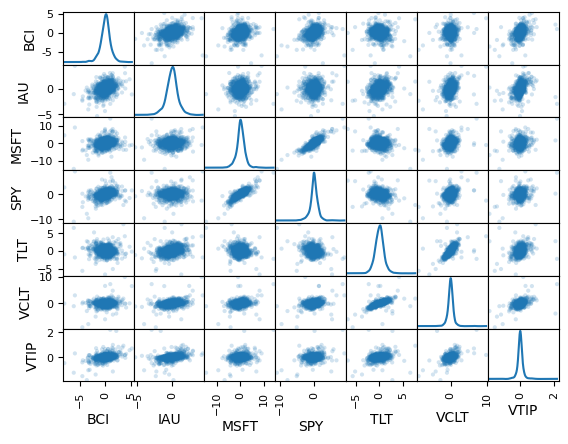

In [5]:
# this might be useless
scatter_matrix(ret, alpha=0.2, diagonal='kde')
plt.show()

In [6]:
# generate random weights
num_assets = len(tickers)
# wgt = (1e4-5e3) * np.random.rand(num_assets, 1) + 5e3  # 굳이 이렇게 할 이유는 없음
wgt = np.random.rand(num_assets)
wgt /= np.sum(wgt)

In [7]:
Sigma = df.cov().values
Corr = df.corr().values
volatility = np.sqrt(wgt.T @ Sigma @ wgt)

print('Cov:', Sigma)
print('Corr:', Corr)
print('Std. Dev.:', volatility)

Cov: [[ 1.07496855e+01  6.50521291e+00  1.61215301e+02  1.65315244e+02
  -2.35200913e+01 -4.96205015e+00  5.74951447e+00]
 [ 6.50521291e+00  2.31867276e+01  3.41220227e+02  2.96775978e+02
   4.86362833e+01  3.47229159e+01  1.10675673e+01]
 [ 1.61215301e+02  3.41220227e+02  6.35480149e+03  5.76897310e+03
   5.57264668e+02  5.03773416e+02  2.01301254e+02]
 [ 1.65315244e+02  2.96775978e+02  5.76897310e+03  5.45941339e+03
   3.74998533e+02  4.30534612e+02  1.84230408e+02]
 [-2.35200913e+01  4.86362833e+01  5.57264668e+02  3.74998533e+02
   3.19920537e+02  1.68482330e+02  1.47259209e+01]
 [-4.96205015e+00  3.47229159e+01  5.03773416e+02  4.30534612e+02
   1.68482330e+02  1.06872826e+02  1.46027700e+01]
 [ 5.74951447e+00  1.10675673e+01  2.01301254e+02  1.84230408e+02
   1.47259209e+01  1.46027700e+01  6.57255811e+00]]
Corr: [[ 1.          0.41204429  0.61681849  0.68240474 -0.40106989 -0.14639614
   0.68401571]
 [ 0.41204429  1.          0.8889228   0.83413438  0.56470234  0.69752987
   0.8

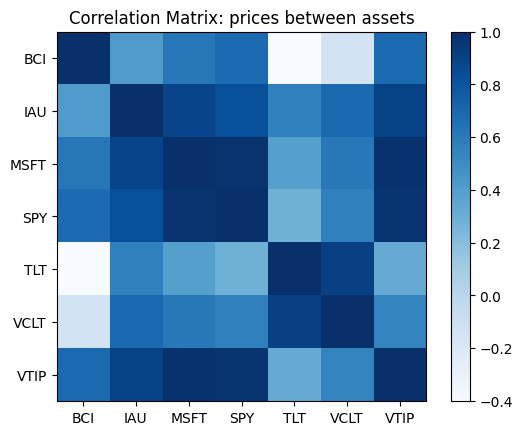

In [8]:
# Corr. visualization
plt.figure()
plt.title('Correlation Matrix: prices between assets')
plt.imshow(Corr, cmap=plt.cm.Blues)
plt.xticks(range(num_assets), df.columns)
plt.yticks(range(num_assets), df.columns)
plt.colorbar()
plt.show()

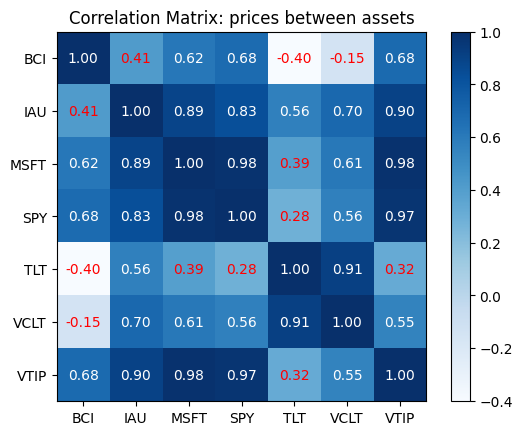

In [9]:
# Correlation Matrix: prices between assets
plt.figure()
plt.title('Correlation Matrix: prices between assets')
im = plt.imshow(Corr, cmap=plt.cm.Blues)
plt.xticks(range(num_assets), df.columns)
plt.yticks(range(num_assets), df.columns)
plt.colorbar(im)

# Corr 값을 텍스트로 표기
for i in range(num_assets):
    for j in range(num_assets):
        plt.text(j, i, f"{Corr[i,j]:.2f}", ha='center', va='center', color='white' if Corr[i,j] > 0.5 else 'red')  # 원 코드는 'red' 대신 'black'

plt.show()

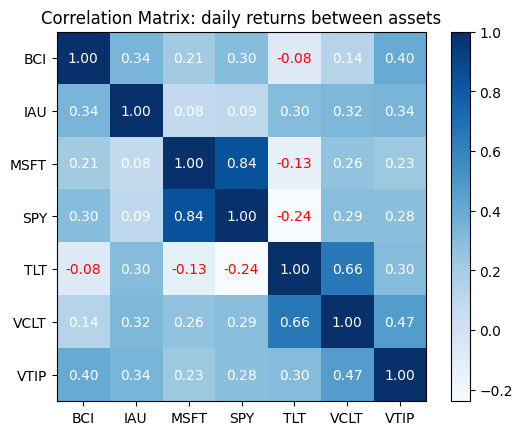

In [10]:
# Correlation Matrix: daily returns between assets
Corr_ret = ret.corr().values

plt.figure()
plt.title('Correlation Matrix: daily returns between assets')
im = plt.imshow(Corr_ret, cmap=plt.cm.Blues)
plt.xticks(range(num_assets), ret.columns)
plt.yticks(range(num_assets), ret.columns)
plt.colorbar(im)

# Corr_ret 값을 텍스트로 표기
for i in range(num_assets):
    for j in range(num_assets):
        plt.text(j, i, f"{Corr_ret[i,j]:.2f}", ha='center', va='center', color='white' if Corr_ret[i,j] > 0.0 else 'red')  # 원 코드는 'red' 대신 'black'

plt.show()

In [11]:
ret.mean() * 100

BCI      2.582010
IAU      3.289484
MSFT    11.903494
SPY      5.078738
TLT      0.276747
VCLT     0.920376
VTIP     1.035831
dtype: float64

In [19]:
# ret 대신 avg_price를 기준으로 num_sum (1000) 번 simulation
num_sim = 1000
W = np.random.rand(num_sim, num_assets)  # 즉, 7 x 1000 행렬
W /= np.sum(W, axis=1).reshape(num_sim, 1)

ret_sim = np.zeros(num_sim)
Sig_sim = np.zeros(num_sim)
avg_price = df.mean().values

for i in range(num_assets):
    ret_sim[i] = np.sum(avg_price * W[i,:])
    Sig_sim[i] = np.sqrt(W[i,:].T @ Sigma @ W[i,:])

points = np.vstack((Sig_sim, ret_sim)).T
hull = ConvexHull(points)

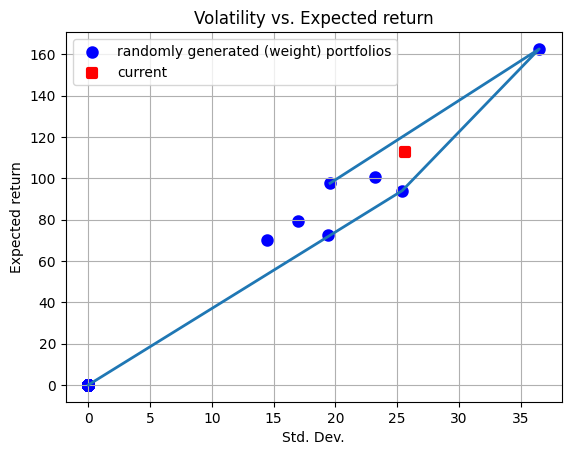

In [21]:
plt.figure()
plt.scatter(Sig_sim, ret_sim, marker='o', color='b', linewidth=3.0, label='randomly generated (weight) portfolios')
plt.scatter(volatility, np.sum(avg_price * wgt), marker='s', color='r', linewidth=3.0, label='current')
plt.plot(points[hull.vertices, 0], points[hull.vertices, 1], linewidth=2.0)
plt.title('Volatility vs. Expected return')
plt.xlabel('Std. Dev.')
plt.ylabel('Expected return')
plt.legend()
plt.grid(True)
plt.show()